# Introduction
***
Cet outil permet de concevoir un survolteur (boost converter) en prévisualisant l'efficacité à l'aide des caractéristiques des composantes choisies. Deux types de topologie seront étudiés, La topologie de base étant la suivante (hard switching):
![dcdc](https://github.com/guimauve007/MPPT-builder/blob/main/assets/dcdc_boost.png?raw=1)



# Entrées
***
Ici, on peut entrer les caractéristiques des composantes choisies pour le survolteur:

In [17]:
# Inductance
L = 220*10**-6 # en H
RL = 12*10**-3 # en Ohm


In [18]:
# Switching FET
RDS_SW = 11*10**-3 # en Ohm
CDS_SW = 400*10**-12 # en F
T_SW = 31*10**-9 # en s -> temps de transition on-off

In [19]:
# Rectifier FET
RDS_RECT = 13*10**-3 # en mOhm

# Équations (topologie de base)
***
La section suivante présente les différentes relations que l'on peut retrouver dans la topologie de base.

## Lexique
Les différentes variables utilisées dans les équations sont définies ci-dessous:

$$D=Duty\ Cycle\ (\%)$$
$$\Delta i=Current\ Ripple\ (A)$$
$$f=Frequency\ (Hz)$$
$$P=Période\ (Secondes)$$
$$L=Inductor\ (H)$$

## Duty Cycle
Relation entre Vin & Vout:

$$D=-\frac{Vin}{Vout}+1$$





In [20]:
def duty_cyle(vin, vout):
    return -(vin/vout)+1

## Ripple Current
Variation de courant dans l'inductance:
$$ \Delta i=\frac{vin*D}{f*L*2} $$


In [21]:
def delta_i(vin, d, f, l):
    return (vin*d)/(f*l*2)

## Pertes de rectification
Au lieu d'utiliser une diode pour la rectification du courant de sortie, on utilise un Mosfet avec une faible résistance en conduction. La perte induite dans cette composante est calculée comme suit:

$$P_{loss}=(I_{out})^2*R_{DS}$$
$$=>P_{loss}=((1-D)*I_{MPP})^2*R_{DS}$$

In [23]:
def ploss_rectifier(d, impp, rds_rect):
    return (((1-d)*impp)**2)*rds_rect

## Pertes de commutation
La perte de commutation est causée par le temps de commutation du mosfet principal. Cette perte est illustrée dans la figure suivante:

![switching loss](https://github.com/guimauve007/MPPT-builder/blob/main/assets/Switching-loss-of-MOSFETs-under-hard-switching.png?raw=1)

Afin de simplifier les calculs, on considérera la moyenne de T_on et T_off, nommé T_sw, pour calculer l'aire de la zone d'énergie dissipée. Pour une période complète, l'énergie perdue est calculée comme suit:

$$E_{loss}=2*T_{SW}*I_{MPP}*V_{DS}$$

La puissance totale dissipée à une fréquence donnée devient donc:

$$P_{loss}=2*T_{SW}*I_{MPP}*V_{DS}*f$$


In [25]:
def ploss_switching(impp, f, t_sw, vout):
    return 2*t_sw*impp*vout*f

## Pertes ESR (inductance)
Pertes en DC de l'inductance principale par sa résistance interne:

$$P_{loss}=R_L*[(I_{MPP})^2+\frac{\Delta I^2}{3}]$$

In [27]:
def ploss_inductor(impp, delta_i, rl):
    return rl*((impp**2)*(delta_i**2)/3)

## Pertes de commutation (Cds)
Pertes de commutation lié au condensateur parallèle $C_{DS}$. Cette perte est causée par la décharge de celui-ci lorsque le Mosfet commute:

$$P_{loss}=\frac{1}{2}*C_{DS}*(V_{out})^2*f$$

In [29]:
def ploss_cds(f, vout, cds_sw):
    return (1/2)*cds_sw*(vout**2)*f

# Pertes totales


In [30]:
def ploss_tot(f, i_mpp, vin, vout):

  # caractéristiques du hacheur
  l = L
  rl = RL
  rds_sw = RDS_SW
  cds_sw = CDS_SW
  t_sw = T_SW
  rds_rect = RDS_RECT

  # variables de fonctionnement
  d = duty_cyle(vin, vout)
  di = delta_i(vin, d, f, l)

  # pertes totales
  return ploss_rectifier(d, i_mpp, rds_rect) + ploss_switching(i_mpp, f, t_sw, vout) + ploss_inductor(i_mpp, di, rl) + ploss_cds(f, vout, cds_sw)

In [31]:
def efficiency(f, i_mpp, vin, vout):
  p_in = vin*i_mpp
  p_out = p_in - ploss_tot(f, i_mpp, vin, vout)

  return p_out/p_in

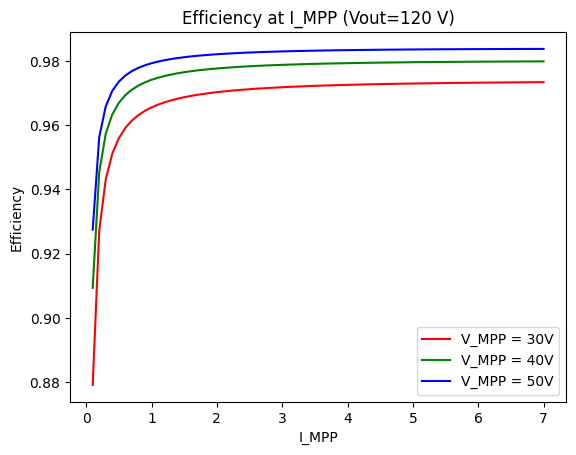

In [37]:
import numpy as np
import matplotlib.pyplot as plt

FREQUENCY = 100000
V_OUT = 120

current = np.arange(0.1, 7.1, 0.1)
E_30V = []
E_40V = []
E_50V = []

for i in current:
    E_30V.append(efficiency(FREQUENCY, i, 30, V_OUT))
    E_40V.append(efficiency(FREQUENCY, i, 40, V_OUT))
    E_50V.append(efficiency(FREQUENCY, i, 50, V_OUT))

plt.plot(current, E_30V, color='r', label="V_MPP = 30V")
plt.plot(current, E_40V, color='g', label="V_MPP = 40V")
plt.plot(current, E_50V, color='b', label="V_MPP = 50V")

plt.xlabel("I_MPP") 
plt.ylabel("Efficiency")
plt.legend() 
plt.title("Efficiency at I_MPP (Vout=120 V)") 

plt.show()